# 📌 Cáncer de Mama en México









## Bibliotecas

In [2]:
import requests
import zipfile
import io
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Funciones

In [3]:
def asignar_grupo_edad(edad):
    if 50 <= edad <= 59:
        return "50 a 59 años"
    elif 20 <= edad <= 29:
        return "20 a 29 años"
    elif 30 <= edad <= 39:
        return "30 a 39 años"
    elif 40 <= edad <= 49:
        return "40 a 49 años"
    elif 60 <= edad <= 74:
        return "60 a 74 años"
    elif 75 <= edad <= 84:
        return "75 a 84 años"
    elif edad >= 85:
        return "85 y más años"
    else:
        return "Fuera de rango"

def limpiar_categorias(df):
    """
    Normaliza valores en columnas categóricas para evitar duplicados en las gráficas.
    """
    # Correcciones específicas por categoría
    reemplazos_sexo = {
        'Hombres': 'Hombre',
        'Mujeres': 'Mujer',
        'No especificado': 'No Especificado',
        'NO ESPECIFICADO': 'No Especificado'
    }

    reemplazos_estado_civil = {
        'Casado(a)': 'Casado',
        'Casada': 'Casado',
        'Divorciado(a)': 'Divorciado',
        'Separado(a)': 'Separado',
        'Soltero(a)': 'Soltero',
        'Viudo(a)': 'Viudo'
    }

    reemplazos_escolaridad = {
        'Bachillerato o Preparatoria incompleto': 'Bachillerato incompleto',
        'Bachillerato o Preparatoria completo': 'Bachillerato completo',
        'No aplica a menores de 3 años': 'No aplica',
        'No aplica a menores de 12 años': 'No aplica',
        'No especificado': 'No Especificado'
    }

    if 'SEXO' in df.columns:
        df['SEXO'] = df['SEXO'].replace(reemplazos_sexo)
    if 'EDO_CIVIL' in df.columns:
        df['EDO_CIVIL'] = df['EDO_CIVIL'].replace(reemplazos_estado_civil)
    if 'ESCOLARIDA' in df.columns:
        df['ESCOLARIDA'] = df['ESCOLARIDA'].replace(reemplazos_escolaridad)

    # Convertir todo a formato limpio (primera letra mayúscula, resto minúsculas)
    for col in ['SEXO', 'EDO_CIVIL', 'ESCOLARIDA']:
        if col in df.columns:
            df[col] = df[col].str.strip().str.title()

    return df


def obtener_url_defunciones(anio):
    anio = int(anio)
    if anio >= 2018:
        return f"https://www.inegi.org.mx/contenidos/programas/edr/datosabiertos/defunciones/{anio}/conjunto_de_datos_defunciones_registradas_{anio}_csv.zip"
    elif anio == 2017:
        return f"https://www.inegi.org.mx/contenidos/programas/edr/datosabiertos/defunciones/{anio}/conjunto_de_datos_defunciones_generales_{anio}_csv.zip"
    elif 2012 <= anio <= 2016:
        return f"https://www.inegi.org.mx/contenidos/programas/edr/datosabiertos/defunciones/{anio}/defunciones_base_datos_{anio}_csv.zip"

    else:
        raise ValueError(f"No hay URL definida para el año {anio}")

def definir_estructura_archivos(anio, ruta_base):
    if anio == 2023:
        return {
            'defunciones': os.path.join(ruta_base, "conjunto_de_datos",
                                        f"conjunto_de_datos_defunciones_registradas_{anio}_csv"),
            'causa_defuncion': os.path.join(ruta_base, "catalogos", "causa_defuncion"),
            'escolaridad': os.path.join(ruta_base, "catalogos", "escolaridad"),
            'estado_civil': os.path.join(ruta_base, "catalogos", "estado_civil"),
            'edad_agrupada': os.path.join(ruta_base, "catalogos", "edad_agrupada"),
            'sexo': os.path.join(ruta_base, "catalogos", "sexo")
        }
    elif anio == 2020:
        return {
            'defunciones': os.path.join(ruta_base, "conjunto_de_datos",
                                        f"conjunto_de_datos_defunciones_registrados_{anio}"),
            'causa_defuncion': os.path.join(ruta_base, "catalogos", "causa_defuncion"),
            'escolaridad': os.path.join(ruta_base, "catalogos", "escolaridad"),
            'estado_civil': os.path.join(ruta_base, "catalogos", "estado_civil"),
            'edad_agrupada': os.path.join(ruta_base, "catalogos", "edad_agrupada"),
            'sexo': os.path.join(ruta_base, "catalogos", "sexo")
        }
    elif anio >= 2018:
        return {
            'defunciones': os.path.join(ruta_base, "conjunto_de_datos",
                                        f"conjunto_de_datos_defunciones_registradas_{anio}"),
            'causa_defuncion': os.path.join(ruta_base, "catalogos", "causa_defuncion"),
            'escolaridad': os.path.join(ruta_base, "catalogos", "escolaridad"),
            'estado_civil': os.path.join(ruta_base, "catalogos", "estado_civil"),
            'edad_agrupada': os.path.join(ruta_base, "catalogos", "edad_agrupada"),
            'sexo': os.path.join(ruta_base, "catalogos", "sexo")
        }
    elif anio == 2017:
        return {
            'defunciones': os.path.join(ruta_base, "conjunto_de_datos",
                                        f"conjunto_de_datos_defunciones_generales_{anio}"),
            'causa_defuncion': os.path.join(ruta_base, "catalogos", "decatcausa"),
            'escolaridad': os.path.join(ruta_base, "catalogos", "deesco"),
            'estado_civil': os.path.join(ruta_base, "catalogos", "deedocony"),
            'edad_agrupada': os.path.join(ruta_base, "catalogos", "deedadagrup"),
            'sexo': os.path.join(ruta_base, "catalogos", "desexo")
        }
    elif 2012 <= anio <= 2016:
        return {
            'defunciones': os.path.join(ruta_base,  "conjunto_de_datos",
                                        f"defunciones_generales_{anio}"),
            'causa_defuncion': os.path.join(ruta_base, "catalogos", "decatcausa"),
            'escolaridad': os.path.join(ruta_base, "catalogos", "deesco"),
            'estado_civil': os.path.join(ruta_base, "catalogos", "deedocony"),
            'edad_agrupada': os.path.join(ruta_base, "catalogos", "deedadagrup"),
            'sexo': os.path.join(ruta_base, "catalogos", "desexo")
        }
    else:
        raise ValueError(f"No tengo mapeo para el año {anio}")

def limpiar_defun23(df):
    # Convertir fechas a datetime (si es necesario)
    df['dia_ocurr'] = pd.to_numeric(df['dia_ocurr'], errors='coerce')
    df['mes_ocurr'] = pd.to_numeric(df['mes_ocurr'], errors='coerce')
    df['anio_ocur'] = pd.to_numeric(df['anio_ocur'], errors='coerce')

    df['fecha_ocurr'] = pd.to_datetime(
        dict(year=df['anio_ocur'], month=df['mes_ocurr'], day=df['dia_ocurr']),
        errors='coerce'
    )
    return df

# --- Relacionar con catálogos (merge) ---
def relacionar_con_catalogo(df, catalogo_df, col_df, col_catalogo, nombre_col_descrip):
    return df.merge(
        catalogo_df,
        left_on=col_df,
        right_on=col_catalogo, how='left').rename(
            columns={'DESCRIP': nombre_col_descrip}
        ).drop(columns=[col_catalogo])

def convertir_edad_a_años(codigo):
    if 1001 <= codigo <= 1097:
        # Horas de vida = menos de 1 año
        return 0
    elif codigo == 1098:
        # Horas no especificadas
        return None
    elif 2001 <= codigo <= 2097:
        # Días de vida = menos de 1 año
        return 0
    elif codigo == 2098:
        # Días no especificados
        return None
    elif 3001 <= codigo <= 3097:
        # Meses de vida = menos de 1 año
        return 0
    elif codigo == 3098:
        # Meses no especificados
        return None
    elif 4001 <= codigo <= 4997:
        # Años completos (4001 = 1 año, 4002 = 2 años, ...)
        return codigo - 4000
    elif codigo == 4998:
        # Años no especificados
        return None
    else:
        # Caso extremo (si no es ninguno de los anteriores, devolver el mismo valor)
        return codigo

# Función para buscar archivo (csv/CSV)
def encontrar_archivo(base):
    for ext in [".csv", ".CSV"]:
        if os.path.exists(base + ext):
            return base + ext
    raise FileNotFoundError(f"No se encontró {base}.csv ni {base}.CSV")

def normalizar_columnas_catalogos(dfs):
    catalogos = ['causa_defuncion', 'escolaridad', 'estado_civil', 'edad_agrupada', 'sexo']

    for nombre in catalogos:
        if nombre in dfs:  # Verificar que el catálogo exista en los datos cargados
            dfs[nombre].columns = dfs[nombre].columns.str.upper()

    return dfs

## Catalogo de estados en México

In [4]:
cat_entidades = pd.DataFrame({
    'CVE_ENT': list(range(1, 33)) + [33, 99],
    'Entidad': [
        "Aguascalientes", "Baja California", "Baja California Sur", "Campeche",
        "Coahuila de Zaragoza", "Colima", "Chiapas", "Chihuahua",
        "Ciudad de México", "Durango", "Guanajuato", "Guerrero",
        "Hidalgo", "Jalisco", "México", "Michoacán de Ocampo",
        "Morelos", "Nayarit", "Nuevo León", "Oaxaca",
        "Puebla", "Querétaro", "Quintana Roo", "San Luis Potosí",
        "Sinaloa", "Sonora", "Tabasco", "Tamaulipas",
        "Tlaxcala", "Veracruz", "Yucatán", "Zacatecas",
        "Residentes en el extranjero", "No especificado"
    ]
})
cat_entidades.head()

,CVE_ENT,Entidad
0,1,Aguascalientes
1,2,Baja California
2,3,Baja California Sur
3,4,Campeche
4,5,Coahuila de Zaragoza


## Fuentes de Datos

### Proyecciones de Población (CONAPO)

La base de datos utilizada en este estudio incluye las **Proyecciones de Población de México y las Entidades Federativas, 1950-2070**, elaboradas por el **Consejo Nacional de Población (CONAPO)**. Esta base contiene el monto poblacional anual con fecha al primero de enero, desagregado por edad y sexo. Está disponible a nivel nacional desde 1950 hasta 2070 y a nivel de entidad federativa desde 1970 hasta 2070.

Para más detalles y acceso a la base de datos oficial, se puede consultar el siguiente enlace:

🔗 [Proyecciones de la Población de México y las Entidades Federativas (2020-2070) - CONAPO](https://datos.gob.mx/busca/dataset/proyecciones-de-la-poblacion-de-mexico-y-de-las-entidades-federativas-2020-2070/)

### Estadísticas de Defunciones Registradas (INEGI)

Otra fuente de datos considerada en este estudio es la base de datos de **Estadísticas de Defunciones Registradas (EDR)**, elaborada por el **Instituto Nacional de Estadística y Geografía (INEGI)**. Esta estadística tiene como objetivo generar y difundir información sobre el fenómeno de la mortalidad en el país, permitiendo conocer y comparar el volumen, la tendencia y las características de la mortalidad en diferentes ámbitos geográficos.

Los datos abarcan el período de **2012 a 2023** y están disponibles en el portal del INEGI.

🔗 [Estadísticas de Defunciones Registradas (EDR) - INEGI](https://www.inegi.org.mx/programas/edr/)


In [6]:
poblacion = pd.read_csv("/content/00_Pob_Inicio_1950_2070.csv", encoding="latin1")
poblacion["EDAD_AGRU"] = poblacion["EDAD"].apply(asignar_grupo_edad)
poblacion=poblacion[poblacion["ENTIDAD"] != "República Mexicana"]
poblacion = poblacion[poblacion["EDAD"] >= 20]

In [7]:
%%time
# Lista de años
anios = range(2012, 2024)

# DataFrame final consolidado
df_final = pd.DataFrame()

for ANIO in anios:
    print(f"🔽 Procesando año {ANIO}")

    # Descargar y extraer ZIP
    url = obtener_url_defunciones(ANIO)
    response = requests.get(url)

    if response.status_code != 200:
        raise Exception(f"Error al descargar {ANIO}: {response.status_code}")

    ruta_base = os.path.join(os.getcwd(), f"defunciones_{ANIO}")
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(ruta_base)

    # Definir estructura de archivos
    archivos = definir_estructura_archivos(ANIO, ruta_base)

    # Cargar DataFrames
    dfs = {}
    for nombre, ruta_base in archivos.items():
        archivo = encontrar_archivo(ruta_base)
        dfs[nombre] = pd.read_csv(archivo, encoding="utf-8")

    columnas = [
        'ent_resid', 'causa_def', 'sexo', 'edad',
        'dia_ocurr', 'mes_ocurr', 'anio_ocur',
        'escolarida', 'edo_civil'
    ]
    dfs['defunciones'] = dfs['defunciones'][columnas]
    # Limpiar la tabla principal
    dfs['defunciones'] = limpiar_defun23(dfs['defunciones'])

    # Relacionar catálogos
    normalizar_columnas_catalogos(dfs)
    dfs['defunciones'] = relacionar_con_catalogo(dfs['defunciones'], dfs['causa_defuncion'], 'causa_def', 'CVE', 'CAUSA_DEF')
    dfs['defunciones'] = relacionar_con_catalogo(dfs['defunciones'], dfs['escolaridad'], 'escolarida', 'CVE', 'ESCOLARIDA')
    dfs['defunciones'] = relacionar_con_catalogo(dfs['defunciones'], dfs['estado_civil'], 'edo_civil', 'CVE', 'EDO_CIVIL')
    dfs['defunciones'] = relacionar_con_catalogo(dfs['defunciones'], dfs['sexo'], 'sexo', 'CVE', 'SEXO')

    # Relacionar con entidades
    df = dfs['defunciones'].merge(cat_entidades, left_on='ent_resid', right_on='CVE_ENT', how='left').drop(columns=['CVE_ENT'])

    # Agregar columna de año
    df['ANIO'] = ANIO
    # Concatenar al DataFrame final
    df_final = pd.concat([df_final, df], ignore_index=True)

df_final = limpiar_categorias(df_final)
df_final['EDAD'] = df_final['edad'].apply(convertir_edad_a_años)
df_final["EDAD_AGRU"] = df_final["EDAD"].apply(asignar_grupo_edad)
# Guardar en archivo final si quieres
df_final.to_csv("defunciones_2012_2023.csv", index=False, encoding='utf-8')
print("✅ Proceso completo")


🔽 Procesando año 2012
🔽 Procesando año 2013


<ipython-input-7-9d7ecd8880ec>:28: DtypeWarning: Columns (42,50) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[nombre] = pd.read_csv(archivo, encoding="utf-8")


🔽 Procesando año 2014
🔽 Procesando año 2015
🔽 Procesando año 2016
🔽 Procesando año 2017
🔽 Procesando año 2018
🔽 Procesando año 2019
🔽 Procesando año 2020
🔽 Procesando año 2021
🔽 Procesando año 2022


<ipython-input-7-9d7ecd8880ec>:28: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[nombre] = pd.read_csv(archivo, encoding="utf-8")


🔽 Procesando año 2023
✅ Proceso completo


In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9231067 entries, 0 to 9231066
Data columns (total 18 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ent_resid    int64         
 1   causa_def    object        
 2   sexo         int64         
 3   edad         int64         
 4   dia_ocurr    int64         
 5   mes_ocurr    int64         
 6   anio_ocur    int64         
 7   escolarida   int64         
 8   edo_civil    int64         
 9   fecha_ocurr  datetime64[ns]
 10  CAUSA_DEF    object        
 11  ESCOLARIDA   object        
 12  EDO_CIVIL    object        
 13  SEXO         object        
 14  Entidad      object        
 15  ANIO         int64         
 16  EDAD         float64       
 17  EDAD_AGRU    object        
dtypes: datetime64[ns](1), float64(1), int64(9), object(7)
memory usage: 1.2+ GB


## Mortalidad

In [22]:
# Filtrar solo defunciones
df_defunciones = df_final[(df_final["EDAD"] >=20.0)]

# Filtrar solo defunciones por tumor maligno
filtro = df_final['CAUSA_DEF'].str.contains(r'\bmaligno\b|\btumor\b', case=False, na=False)
df_defunciones_tumor_maligno = df_final[(df_final["EDAD"] >=20.0) & (filtro)]

# Filtrar solo defunciones de mujeres
df_defunciones_mujeres = df_final[
    (df_final["SEXO"] == "Mujer") & (df_final["EDAD"] >=20.0)]

causas_cancer_mama = [
    "Tumor maligno de la mama, parte no especificada",
    "Tumor maligno del pezón y aréola mamaria",
    "Tumor maligno de la porción central de la mama",
    "Tumor maligno del cuadrante superior externo de la mama",
    "Tumor maligno del cuadrante inferior interno de la mama",
    "Tumor maligno del cuadrante inferior externo de la mama",
    "Tumor maligno del cuadrante superior interno de la mama",
    "Carcinoma in situ de la mama, parte no especificada",
    "Tumor maligno de la prolongación axilar de la mama",
    "Otros carcinomas in situ de la mama"
]
df_defunciones_mujeres_cancer_mama = df_defunciones_mujeres[
    df_defunciones_mujeres['CAUSA_DEF'].isin(causas_cancer_mama)]

df_defunciones_cancer_mama = df_defunciones[
    df_defunciones['CAUSA_DEF'].isin(causas_cancer_mama)]

# Agrupar conteo de muertes por AÑO
muertes_tumor_maligno = df_defunciones_tumor_maligno.groupby(["ANIO"]).size().reset_index(name="num_muertes_maligno")

muertes_mama = df_defunciones_cancer_mama.groupby(["ANIO"]).size().reset_index(name="num_muertes_mama")

muertes_m_mama = df_defunciones_mujeres_cancer_mama.groupby(["ANIO"]).size().reset_index(name="num_muertes_mujeres_mama")

muertes_m_totales = df_defunciones_mujeres.groupby(["ANIO"]).size().reset_index(name="num_muertes_mujeres")

muertes_totales = df_defunciones.groupby(["ANIO"]).size().reset_index(name="num_muertes_total")


# Unir datos de muertes
mortalidad = pd.merge(muertes_m_totales, muertes_totales, left_on=["ANIO"], right_on=["ANIO"])
mortalidad = pd.merge(mortalidad, muertes_tumor_maligno, left_on=["ANIO"], right_on=["ANIO"])
mortalidad = pd.merge(mortalidad, muertes_m_mama, left_on=["ANIO"], right_on=["ANIO"])
mortalidad = pd.merge(mortalidad, muertes_mama, left_on=["ANIO"], right_on=["ANIO"])

mortalidad["porcentaje_mama"] = (mortalidad["num_muertes_mama"] / mortalidad["num_muertes_maligno"]) * 100
mortalidad["porcentaje_mama_mujeres"] = (mortalidad["num_muertes_mujeres_mama"] / mortalidad["num_muertes_mama"]) * 100

# Seleccionar columnas finales
mortalidad_final = mortalidad[["ANIO", "num_muertes_total", "num_muertes_maligno",
                                         "num_muertes_mama", "num_muertes_mujeres_mama",
                                         "porcentaje_mama", "porcentaje_mama_mujeres"]]
mortalidad_final

,ANIO,num_muertes_total,num_muertes_maligno,num_muertes_mama,num_muertes_mujeres_mama,porcentaje_mama,porcentaje_mama_mujeres
0,2012,548155,64789,5652,5602,8.723703,99.115357
1,2013,572720,66450,5591,5543,8.413845,99.141477
2,2014,584754,69509,6045,5991,8.696716,99.106700
3,2015,607556,71591,6295,6264,8.793005,99.507546
4,2016,638386,74292,6689,6646,9.003661,99.357154
5,2017,653861,75809,6887,6852,9.084673,99.491796
6,2018,674726,77504,7309,7256,9.430481,99.274867
7,2019,701225,80313,7578,7525,9.435583,99.300607
8,2020,1043012,82385,7880,7821,9.564848,99.251269
9,2021,1078317,83129,7951,7902,9.564653,99.383725


In [99]:
# Filtrar solo defunciones de mujeres
df_defunciones_mujeres = df_final[
    (df_final["SEXO"] == "Mujer") & (df_final["EDAD"] >=20.0)]

causas_cancer_mama = [
    "Tumor maligno de la mama, parte no especificada",
    "Tumor maligno del pezón y aréola mamaria",
    "Tumor maligno de la porción central de la mama",
    "Tumor maligno del cuadrante superior externo de la mama",
    "Tumor maligno del cuadrante inferior interno de la mama",
    "Tumor maligno del cuadrante inferior externo de la mama",
    "Tumor maligno del cuadrante superior interno de la mama",
    "Carcinoma in situ de la mama, parte no especificada",
    "Tumor maligno de la prolongación axilar de la mama",
    "Otros carcinomas in situ de la mama"
]
df_defunciones_mujeres_cancer_mama = df_defunciones_mujeres[
    df_defunciones_mujeres['CAUSA_DEF'].isin(causas_cancer_mama)]


# Agrupar conteo de muertes por AÑO
muertes_m_mama = df_defunciones_mujeres_cancer_mama.groupby(["ANIO"]).size().reset_index(name="num_muertes")


# Filtrar solo población de mujeres
df_poblacion_mujeres = poblacion[poblacion["SEXO"] == "Mujeres"]

# Agrupar población total por año y entidad
poblacion_agrupada = df_poblacion_mujeres.groupby(["AÑO"]).agg({'POBLACION': 'sum'}).reset_index()

# Unir datos de muertes con población
tasa_mortalidad_nacional = pd.merge(muertes_m_totales, poblacion_agrupada, left_on=["ANIO"], right_on=["AÑO"])
tasa_mortalidad_nacional = pd.merge(tasa_mortalidad_nacional, muertes_m_mama, left_on=["ANIO"], right_on=["ANIO"])

# Calcular la tasa de mortalidad por cada 100,000 mujeres
tasa_mortalidad_nacional["tasa_x_100mil"] = (tasa_mortalidad_nacional["num_muertes"] / tasa_mortalidad_nacional["POBLACION"]) * 100000

# Seleccionar columnas finales
tasa_mortalidad_final_nacional = tasa_mortalidad_nacional[["ANIO","num_muertes", "POBLACION", "tasa_x_100mil"]]
tasa_mortalidad_final_nacional['Entidad'] = 'Nacional'
tasa_mortalidad_final_nacional

<ipython-input-99-f2943b18d2f1>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasa_mortalidad_final_nacional['Entidad'] = 'Nacional'


,ANIO,num_muertes,POBLACION,tasa_x_100mil,Entidad
0,2012,5602,37134656,15.085639,Nacional
1,2013,5543,37976543,14.595852,Nacional
2,2014,5991,38817622,15.433712,Nacional
3,2015,6264,39603528,15.816773,Nacional
4,2016,6646,40347601,16.471859,Nacional
5,2017,6852,41058359,16.688441,Nacional
6,2018,7256,41787737,17.363946,Nacional
7,2019,7525,42530164,17.693325,Nacional
8,2020,7821,43281790,18.069955,Nacional
9,2021,7902,43881463,18.007604,Nacional


In [100]:
# Filtrar solo defunciones de mujeres
df_defunciones_mujeres = df_final[(df_final["SEXO"] == "Mujer") & (df_final["EDAD"] >=20.0)]
causas_cancer_mama = [
    "Tumor maligno de la mama, parte no especificada",
    "Tumor maligno del pezón y aréola mamaria",
    "Tumor maligno de la porción central de la mama",
    "Tumor maligno del cuadrante superior externo de la mama",
    "Tumor maligno del cuadrante inferior interno de la mama",
    "Tumor maligno del cuadrante inferior externo de la mama",
    "Tumor maligno del cuadrante superior interno de la mama",
    "Carcinoma in situ de la mama, parte no especificada",
    "Tumor maligno de la prolongación axilar de la mama",
    "Otros carcinomas in situ de la mama"
]
df_defunciones_mujeres_cancer_mama = df_defunciones_mujeres[df_defunciones_mujeres['CAUSA_DEF'].isin(causas_cancer_mama)]

# Agrupar conteo de muertes por AÑO y ENTIDAD
muertes = df_defunciones_mujeres_cancer_mama.groupby(["ANIO", "Entidad"]).size().reset_index(name="num_muertes")

# Filtrar solo población de mujeres
df_poblacion_mujeres = poblacion[poblacion["SEXO"] == "Mujeres"]

# Agrupar población total por año y entidad
poblacion_agrupada = df_poblacion_mujeres.groupby(["AÑO", "ENTIDAD"]).agg({'POBLACION': 'sum'}).reset_index()

# Unir datos de muertes con población
tasa_mortalidad = pd.merge(muertes, poblacion_agrupada, left_on=["ANIO", "Entidad"], right_on=["AÑO", "ENTIDAD"])

# Calcular la tasa de mortalidad por cada 100,000 mujeres
tasa_mortalidad["tasa_x_100mil"] = (tasa_mortalidad["num_muertes"] / tasa_mortalidad["POBLACION"]) * 100000

# Seleccionar columnas finales
tasa_mortalidad_final = tasa_mortalidad[["ANIO", "Entidad", "num_muertes", "POBLACION", "tasa_x_100mil"]]
tasa_mortalidad_final = pd.concat([tasa_mortalidad_final, tasa_mortalidad_final_nacional])
tasa_mortalidad_final

,ANIO,Entidad,num_muertes,POBLACION,tasa_x_100mil
0,2012,Aguascalientes,69,380004,18.157704
1,2012,Baja California,180,1003393,17.939133
2,2012,Baja California Sur,36,204594,17.595824
3,2012,Campeche,21,268606,7.818143
4,2012,Chiapas,149,1418670,10.502795
...,...,...,...,...,...
7,2019,Nacional,7525,42530164,17.693325
8,2020,Nacional,7821,43281790,18.069955
9,2021,Nacional,7902,43881463,18.007604
10,2022,Nacional,7813,44457677,17.574018


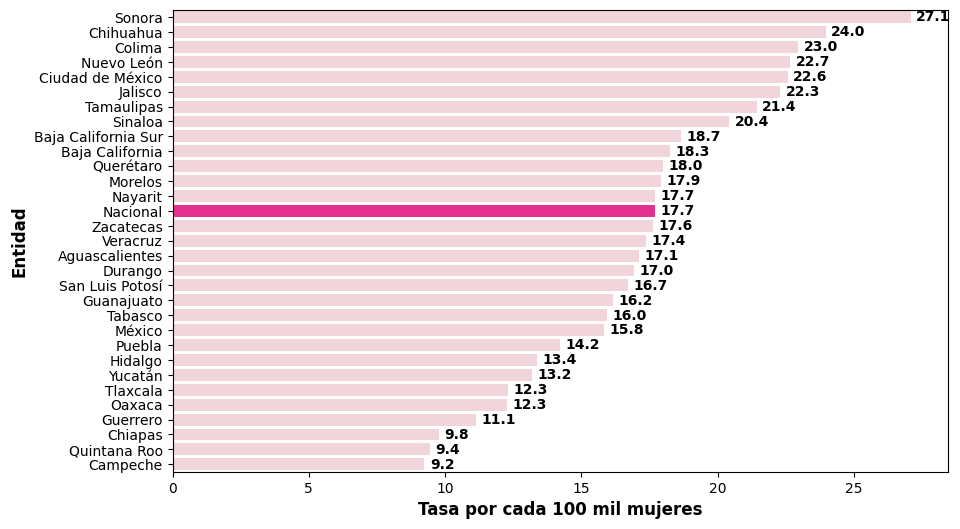

In [106]:
# Definir el año de interés
ANIO = 2023

# Filtrar datos solo del año 2023
df_2023 = tasa_mortalidad_final[tasa_mortalidad_final["ANIO"] == ANIO]

# Ordenar por tasa de mortalidad de mayor a menor
df = df_2023.sort_values(by="tasa_x_100mil", ascending=False)

# Identificar la entidad "Nacional" y darle un rosa más fuerte
colores = ["deeppink" if entidad == "Nacional" else "#f6d0d7" for entidad in df["Entidad"]]


# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

sns.barplot(x=df["tasa_x_100mil"], y=df["Entidad"], hue=df["Entidad"], palette=colores, legend=False)

# Agregar etiquetas con el porcentaje encima de cada barra
for index, value in enumerate(df["tasa_x_100mil"]):
    plt.text(value + 0.2, index, f"{value:.1f}", ha='left', va='center', fontsize=10, fontweight='bold')

# Personalización del gráfico
plt.ylabel("Entidad", fontsize=12, fontweight='bold')
plt.xlabel("Tasa por cada 100 mil mujeres", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar el gráfico
plt.show()

In [58]:
# Filtrar solo defunciones de mujeres

df_defunciones_mujeres = df_final[(df_final["SEXO"] == "Mujer") & (df_final["EDAD"] >=20.0)]
causas_cancer_mama = [
    "Tumor maligno de la mama, parte no especificada",
    "Tumor maligno del pezón y aréola mamaria",
    "Tumor maligno de la porción central de la mama",
    "Tumor maligno del cuadrante superior externo de la mama",
    "Tumor maligno del cuadrante inferior interno de la mama",
    "Tumor maligno del cuadrante inferior externo de la mama",
    "Tumor maligno del cuadrante superior interno de la mama",
    "Carcinoma in situ de la mama, parte no especificada",
    "Tumor maligno de la prolongación axilar de la mama",
    "Otros carcinomas in situ de la mama"
]
df_defunciones_mujeres_cancer_mama = df_defunciones_mujeres[df_defunciones_mujeres['CAUSA_DEF'].isin(causas_cancer_mama)]


# Agrupar conteo de muertes por AÑO y EDAD_AGRU
muertes =df_defunciones_mujeres_cancer_mama.groupby(["ANIO", "EDAD_AGRU"]).size().reset_index(name="num_muertes")

# Filtrar solo población de mujeres
df_poblacion_mujeres = poblacion[poblacion["SEXO"] == "Mujeres"]



# Agrupar población total por AÑO, ENTIDAD y grupo de edad
poblacion_agrupada = df_poblacion_mujeres.groupby(["AÑO", "EDAD_AGRU"]).agg({'POBLACION': 'sum'}).reset_index()

# Unir datos de muertes con población
tasa_mortalidad = pd.merge(muertes, poblacion_agrupada, left_on=["ANIO", "EDAD_AGRU"], right_on=["AÑO", "EDAD_AGRU"])

# Calcular la tasa de mortalidad por cada 100,000 mujeres
tasa_mortalidad["tasa_x_100mil"] = (tasa_mortalidad["num_muertes"] / tasa_mortalidad["POBLACION"]) * 100000

# Seleccionar columnas finales
tasa_mortalidad_final = tasa_mortalidad[["ANIO", "EDAD_AGRU", "num_muertes", "POBLACION", "tasa_x_100mil"]]
tasa_mortalidad_final = tasa_mortalidad_final[tasa_mortalidad_final.EDAD_AGRU != "Fuera de rango"]
tasa_mortalidad_final

,ANIO,EDAD_AGRU,num_muertes,POBLACION,tasa_x_100mil
0,2012,20 a 29 años,51,10382549,0.491209
1,2012,30 a 39 años,436,8913043,4.891708
2,2012,40 a 49 años,1075,7203331,14.923651
3,2012,50 a 59 años,1532,4918268,31.149177
4,2012,60 a 74 años,1565,4115836,38.023867
...,...,...,...,...,...
79,2023,40 a 49 años,1360,8691366,15.647713
80,2023,50 a 59 años,1959,7024192,27.889329
81,2023,60 a 74 años,2603,6017964,43.253831
82,2023,75 a 84 años,1007,1705774,59.034784


In [62]:
# Suponiendo que 'tasa_mortalidad' tiene las columnas: 'ANIO', 'GRUPO_EDAD', 'tasa_x_100mil'
tabla_dinamica = tasa_mortalidad_final[tasa_mortalidad_final.ANIO>=2018].pivot_table(
    values="tasa_x_100mil",
    index="EDAD_AGRU",
    columns="ANIO",
    aggfunc="mean"  # Usamos la media en caso de que haya múltiples registros por grupo/año
)

In [63]:
tabla_dinamica

ANIO,2018,2019,2020,2021,2022,2023
EDAD_AGRU,,,,,,
20 a 29 años,0.594481,0.455485,0.607989,0.696965,0.488390,0.560982
30 a 39 años,4.671596,5.145978,4.593295,4.703254,4.698400,4.672425
40 a 49 años,16.113450,16.379049,16.744647,16.326372,15.269849,15.647713
50 a 59 años,31.949415,30.886514,31.478954,29.904701,28.868204,27.889329
60 a 74 años,43.316982,43.812961,45.200800,43.705570,42.715516,43.253831
75 a 84 años,57.789803,59.872571,55.936583,61.888328,61.823483,59.034784
85 y más años,82.787806,83.899261,88.481644,93.161514,92.709861,91.269102


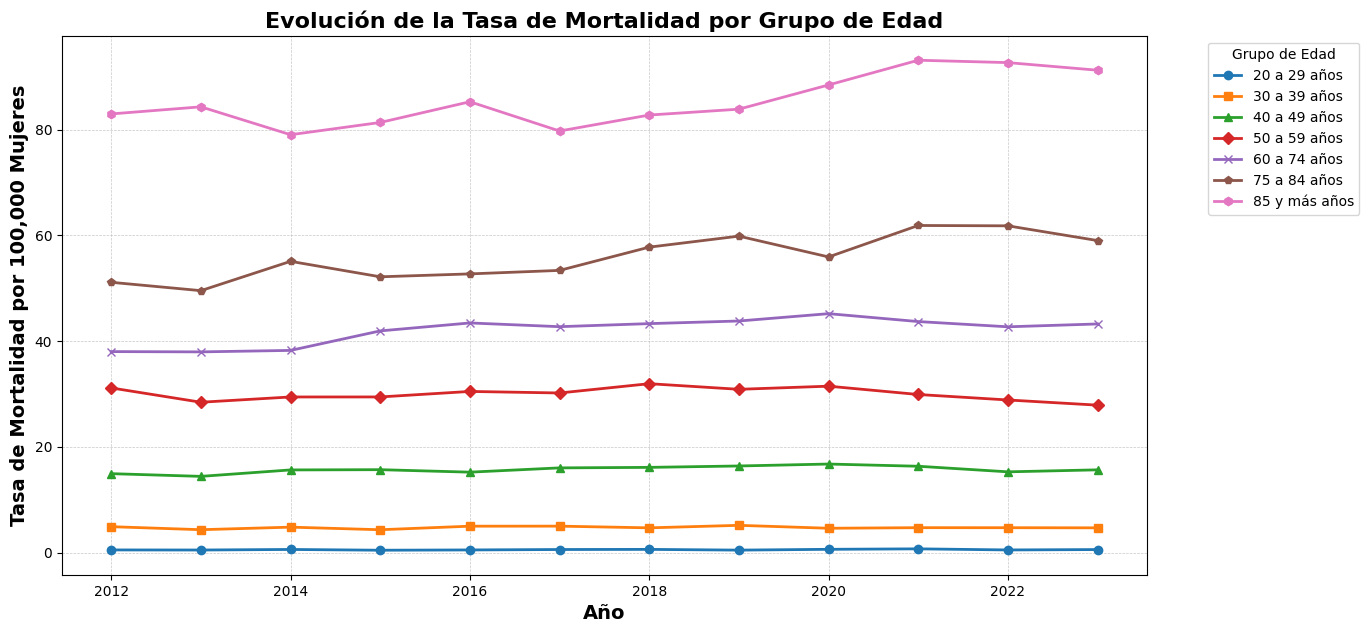

In [57]:
line_styles = ['o-', 's-', '^-', 'D-', 'x-', 'p-', 'h-']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Crear la figura más grande para mejor visualización
plt.figure(figsize=(14, 7))

# Graficar cada grupo de edad con colores y estilos mejorados
for i, grupo in enumerate(tasa_mortalidad_final["EDAD_AGRU"].unique()):
    df_filtrado = tasa_mortalidad_final[tasa_mortalidad_final["EDAD_AGRU"] == grupo]
    plt.plot(df_filtrado["ANIO"], df_filtrado["tasa_x_100mil"],
             line_styles[i % len(line_styles)],
             color=colors[i % len(colors)],
             label=grupo, markersize=6, linewidth=2)

# Mejoras en etiquetas y título
plt.xlabel("Año", fontsize=14, fontweight='bold')
plt.ylabel("Tasa de Mortalidad por 100,000 Mujeres", fontsize=14, fontweight='bold')
plt.title("Evolución de la Tasa de Mortalidad por Grupo de Edad", fontsize=16, fontweight='bold')

# Ajuste de leyenda y cuadrícula
plt.legend(title="Grupo de Edad", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# Mostrar la gráfica mejorada
plt.show()


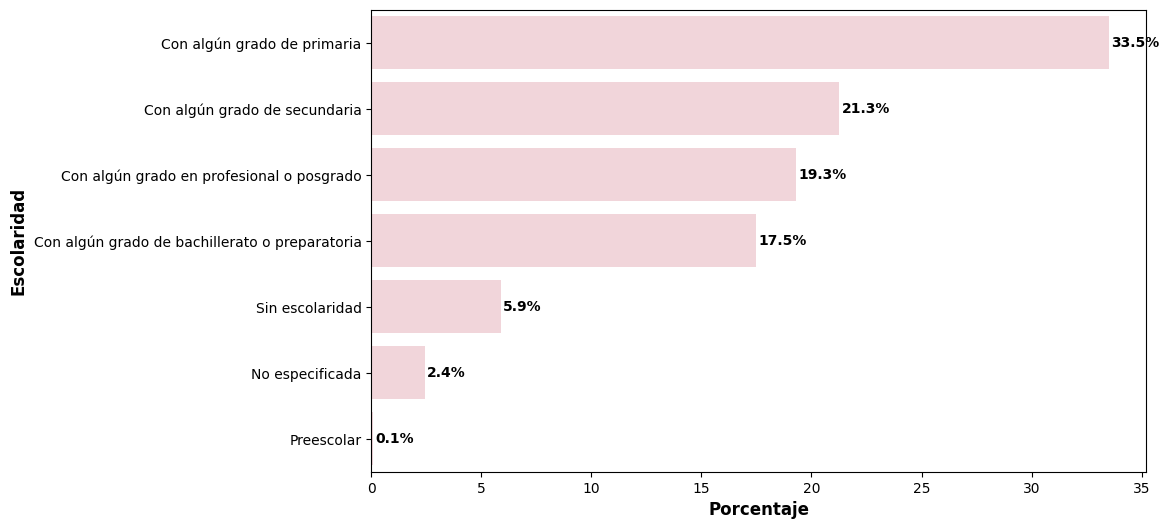

In [119]:

df_defunciones_mujeres = df_final[(df_final["SEXO"] == "Mujer") & (df_final["EDAD"] >=20.0) & (df_final["ANIO"] == 2023)]
causas_cancer_mama = [
    "Tumor maligno de la mama, parte no especificada",
    "Tumor maligno del pezón y aréola mamaria",
    "Tumor maligno de la porción central de la mama",
    "Tumor maligno del cuadrante superior externo de la mama",
    "Tumor maligno del cuadrante inferior interno de la mama",
    "Tumor maligno del cuadrante inferior externo de la mama",
    "Tumor maligno del cuadrante superior interno de la mama",
    "Carcinoma in situ de la mama, parte no especificada",
    "Tumor maligno de la prolongación axilar de la mama",
    "Otros carcinomas in situ de la mama"
]
df = df_defunciones_mujeres[df_defunciones_mujeres['CAUSA_DEF'].isin(causas_cancer_mama)]

mapeo_escolaridad = {
    "Bachillerato O Preparatoria Completo": "Con algún grado de bachillerato o preparatoria",
    "Bachillerato O Preparatoria Incompleto": "Con algún grado de bachillerato o preparatoria",
    "Secundaria Completa": "Con algún grado de secundaria",
    "Secundaria Incompleta": "Con algún grado de secundaria",
    "Primaria Completa": "Con algún grado de primaria",
    "Primaria Incompleta": "Con algún grado de primaria",
    "Profesional": "Con algún grado en profesional o posgrado",
    "Posgrado": "Con algún grado en profesional o posgrado",
    "Prescolar": "No especificada",
    "No Especificado": "No especificada",
    "Sin Escolaridad": "Sin escolaridad"
}

# Aplicar el mapeo en el DataFrame
df = df.copy()  # Agregar esta línea antes de modificar la columna
df["ESCOLARIDA"] = df["ESCOLARIDA"].replace(mapeo_escolaridad)
# Agrupar por ESCOLARIDA y contar ocurrencias
df_grouped = df.groupby("ESCOLARIDA").size().reset_index(name="count")

# Calcular el porcentaje
df_grouped["percentage"] = df_grouped["count"] / df_grouped["count"].sum() * 100
df_grouped = df_grouped.sort_values(by="percentage", ascending=False)


# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

ax = sns.barplot(y="ESCOLARIDA", x="percentage", data=df_grouped,
                 hue="ESCOLARIDA",   palette=["#f6d0d7"] * len(df_grouped),
                 legend=False)

# Agregar etiquetas con el porcentaje correctamente sobre las barras
for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}%',  # Usar get_width() en lugar de get_height()
                (p.get_x() + p.get_width() + 0.1, p.get_y() + p.get_height() / 2),  # Ajustar la posición
                ha='left', va='center', fontsize=10, fontweight="bold")

# Personalizar la gráfica
plt.ylabel("Escolaridad", fontsize=12, fontweight="bold")
plt.xlabel("Porcentaje", fontsize=12, fontweight="bold")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar la gráfica
plt.show()

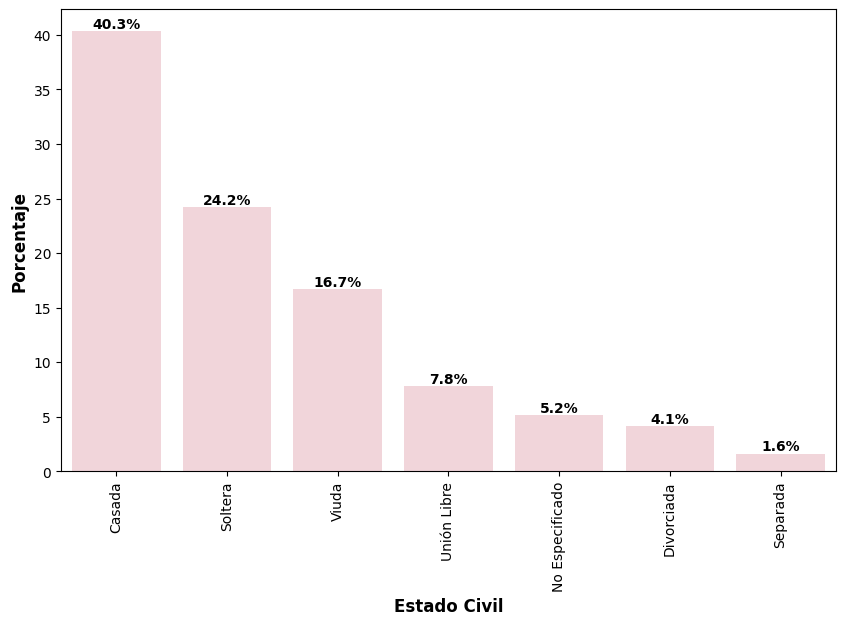

In [121]:

df_defunciones_mujeres = df_final[(df_final["SEXO"] == "Mujer") & (df_final["EDAD"] >=20.0) & (df_final["ANIO"] == 2023)]
causas_cancer_mama = [
    "Tumor maligno de la mama, parte no especificada",
    "Tumor maligno del pezón y aréola mamaria",
    "Tumor maligno de la porción central de la mama",
    "Tumor maligno del cuadrante superior externo de la mama",
    "Tumor maligno del cuadrante inferior interno de la mama",
    "Tumor maligno del cuadrante inferior externo de la mama",
    "Tumor maligno del cuadrante superior interno de la mama",
    "Carcinoma in situ de la mama, parte no especificada",
    "Tumor maligno de la prolongación axilar de la mama",
    "Otros carcinomas in situ de la mama"
]
df = df_defunciones_mujeres[df_defunciones_mujeres['CAUSA_DEF'].isin(causas_cancer_mama)]


# Agrupar por ESCOLARIDA y contar ocurrencias
df_grouped = df.groupby("EDO_CIVIL").size().reset_index(name="count")

mapeo_estado_civil = {
    "Casado": "Casada",
    "Soltero": "Soltera",
    "Viudo": "Viuda",
    "Unión Libre": "Unión Libre",
    "No Especificado": "No Especificado",
    "Divorciado": "Divorciada",
    "Separado": "Separada"
}

# Aplicar el cambio en las etiquetas
df_grouped["EDO_CIVIL"] = df_grouped["EDO_CIVIL"].replace(mapeo_estado_civil)

# Calcular el porcentaje
df_grouped["percentage"] = df_grouped["count"] / df_grouped["count"].sum() * 100

df_grouped = df_grouped.sort_values(by="percentage", ascending=False)

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Crear gráfico de barras con la paleta corregida
ax = sns.barplot(x="EDO_CIVIL", y="percentage",
                 data=df_grouped, hue="EDO_CIVIL",  palette=["#f6d0d7"] * len(df_grouped),
                 legend=False)

# Agregar etiquetas con el porcentaje encima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight="bold")

# Personalizar la gráfica
plt.xlabel("Estado Civil", fontsize=12, fontweight="bold")
plt.ylabel("Porcentaje", fontsize=12, fontweight="bold")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Mostrar la gráfica
plt.show()